In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pprint import pprint

In [2]:
def load_artembev():
    res = pd.read_excel('../data/1Artembev_PhC_sport_and_tripms.xls', header=0)
    res = res[['Physiological Cost (PhC)', 'TRIMP1', 'TRIMP2', 'TRIMP3', 'TRIMP4']]
    res['PhC'] = res['Physiological Cost (PhC)']
    res.drop(columns=["Physiological Cost (PhC)"], inplace=True)
    return res[11::]

In [3]:
def load_others():
    columns_to_remain = ['PhC', "t1(passive,slow)", "t2(passive,fast)", "t3(active,slow)", 't4(active,fast)']
    prokopbev = pd.read_excel('../data/2Prokopbev_PhC_sport_and_tripms.xls', header=0)
    prokopbev = prokopbev[columns_to_remain]
    prokopbev['TRIMP1'] = prokopbev["t1(passive,slow)"]
    prokopbev['TRIMP2'] = prokopbev["t2(passive,fast)"]
    prokopbev['TRIMP3'] = prokopbev["t3(active,slow)"]
    prokopbev['TRIMP4'] = prokopbev['t4(active,fast)']
    volkov = pd.read_excel('../data/3Volkov_PhC_sport_and_tripms.xls', header=0)
    volkov = volkov[columns_to_remain]
    volkov['TRIMP1'] = volkov["t1(passive,slow)"]
    volkov['TRIMP2'] = volkov["t2(passive,fast)"]
    volkov['TRIMP3'] = volkov["t3(active,slow)"]
    volkov['TRIMP4'] = volkov['t4(active,fast)']
    
    cols_to_remove = ["t1(passive,slow)", "t2(passive,fast)", "t3(active,slow)", 't4(active,fast)']
    
    prokopbev.drop(columns=cols_to_remove, inplace=True)
    volkov.drop(columns=cols_to_remove, inplace=True)
    return prokopbev[8::], volkov[34::]

In [4]:
# import sklearn.tree
# help(sklearn.tree._tree.Tree)

In [5]:
# def boost_tree(X, y, tree_depth=None):
#     from sklearn.tree._tree import TREE_LEAF
#     tree = DecisionTreeRegressor(max_depth=tree_depth)
#     tree.fit(X, y)
# #     print(tree.n_outputs_)
# #     print(tree.n_classes_)
# #     print(tree.n_features_)
# #     print(tree.tree_.node_count)
#     leaves_count = np.sum([tree.tree_.children_left[i] == TREE_LEAF and tree.tree_.children_right[i] == TREE_LEAF
#      for i in range(tree.tree_.node_count)])
# #     print(leaves_count)
#     y_pred = tree.predict(X)
    
#     linear = {}
    
#     for val in np.unique(y_pred):
#         linreg = LinearRegression()
        
#         X_node = X[y_pred == val]
#         y_node = y[y_pred == val]
        
#         linreg.fit()
        
#         linear.update({val: })
        
        
#     plt.figure(figsize=(7,7))
#     sns.scatterplot(y, y_pred)
#     sns.scatterplot(y, y)
#     plt.xlabel('Истинное значение')
#     plt.ylabel('Прогноз')

In [6]:
class TreeBoosting:
    def __init__(self, depth):
        self.linears = {}
        self.tree = None
        self.depth = depth
    
    def fit(self, X, y):
        from sklearn.tree._tree import TREE_LEAF
        self.tree = DecisionTreeRegressor(max_depth=self.depth)
        self.tree.fit(X, y)
        
        leaves_count = np.sum([self.tree.tree_.children_left[i] == TREE_LEAF and 
                                    self.tree.tree_.children_right[i] == TREE_LEAF 
                                    for i in range(self.tree.tree_.node_count)])
        y_pred = self.tree.predict(X)

        self.possible_values = np.unique(y_pred)
        
#         possible_values = np.vstack((possible_values, np.arange(possible_values.shape[0])))
        
#         print(self.possible_values)
        
        for i in range(self.possible_values.shape[0]):
            linreg = LinearRegression(fit_intercept=True)

            X_node = X[y_pred == self.possible_values[i]]
            y_node = y[y_pred == self.possible_values[i]]
            
            print(f'Output #{i}\nLength {y_node.shape[0]}')

            linreg.fit(X_node, y_node)

            self.linears.update({i: linreg})
            
    def predict(self, X):
        idx = self.tree.predict(X)
        
        for i in range(self.possible_values.shape[0]):
            idx[idx == self.possible_values[i]] = i
        
#         print(idx)
#         print(type(idx))
        
        res = idx.copy()
        
        for i in range(res.shape[0]):
            res[i] = self.linears[int(res[i])].predict([X.iloc[i]])[0]
            
#         print(res)
        
        return res

In [7]:
artembev = load_artembev().dropna()
y = artembev['PhC']
X = artembev.drop(columns=['PhC'])

Output #0
Length 59
Output #1
Length 14
-0.09229730522025159


Text(0, 0.5, 'Прогноз')

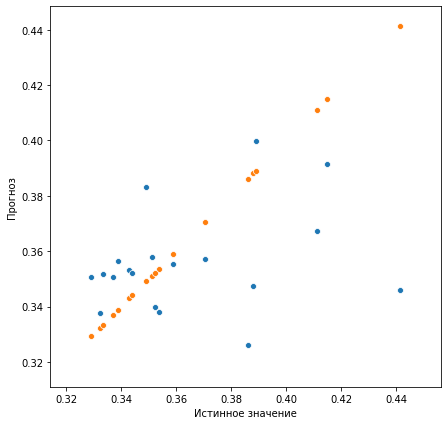

In [8]:
tree = TreeBoosting(1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

print(r2_score(y_test, y_pred))
plt.figure(figsize=(7,7))
sns.scatterplot(y_test, y_pred)
sns.scatterplot(y_test, y_test)
plt.xlabel('Истинное значение')
plt.ylabel('Прогноз')

## Артемьев, среднее за 3 дня

In [52]:
artembev = load_artembev()

In [53]:
data = artembev.copy()
# data.drop(columns=['day number'], inplace=True)
data["PhC"] = data["PhC"][1::]
cols_to_drop = []
for col in data.columns:
    data[col+'_mean_3_days'] = np.asarray([data.loc[i-1:i+1, col].mean() for i in data.index])
#     data.drop(columns=[col], inplace=True)
    cols_to_drop.append(col)
OLD_PHC_COLNAME = "PhC_mean_3_days"
NEW_PHC_COLNAME = 'PhC_mean_target_3_days'
data[NEW_PHC_COLNAME] = data[OLD_PHC_COLNAME][3::].tolist() + 3*[np.nan]
data[OLD_PHC_COLNAME] = np.asarray([data.loc[i-2:i, "PhC"].mean() for i in data.index])
# data['const'] = np.full(data.shape[0], 1)
# cols_to_drop.append(OLD_PHC_COLNAME)
data.drop(columns=cols_to_drop, inplace=True)
data.dropna(inplace=True)
data.head()

,TRIMP1_mean_3_days,TRIMP2_mean_3_days,TRIMP3_mean_3_days,TRIMP4_mean_3_days,PhC_mean_3_days,PhC_mean_target_3_days
12,994.960748,103.188621,1260.987536,758.520146,0.395014,0.408444
13,997.482226,61.388053,1853.448052,1052.005165,0.393683,0.378842
14,770.478993,36.772901,1997.440934,1154.630564,0.393683,0.349240
15,981.762669,177.930531,1626.721428,784.579500,0.400398,0.372751
16,958.164133,173.953128,1848.569418,1049.974340,0.408444,0.396262


In [54]:
y = data[NEW_PHC_COLNAME]
X = data.drop(columns=[NEW_PHC_COLNAME])

In [55]:
X.head()

,TRIMP1_mean_3_days,TRIMP2_mean_3_days,TRIMP3_mean_3_days,TRIMP4_mean_3_days,PhC_mean_3_days
12,994.960748,103.188621,1260.987536,758.520146,0.395014
13,997.482226,61.388053,1853.448052,1052.005165,0.393683
14,770.478993,36.772901,1997.440934,1154.630564,0.393683
15,981.762669,177.930531,1626.721428,784.579500,0.400398
16,958.164133,173.953128,1848.569418,1049.974340,0.408444


Output #0
Length 75
Output #1
Length 24
0.5516590644182973


Text(0, 0.5, 'Прогноз')

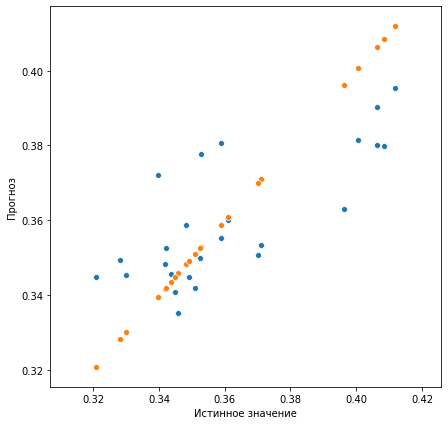

In [56]:
tree = TreeBoosting(1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

print(r2_score(y_test, y_pred))
plt.figure(figsize=(7,7))
sns.scatterplot(y_test, y_pred)
sns.scatterplot(y_test, y_test)
plt.xlabel('Истинное значение')
plt.ylabel('Прогноз')

## Волков, среднее за 3 дня

In [57]:
_, volkov = load_others()

In [58]:
data = volkov.copy()
# data.drop(columns=['day number'], inplace=True)
data["PhC"] = data["PhC"][1::]
cols_to_drop = []
for col in data.columns:
    data[col+'_mean_3_days'] = np.asarray([data.loc[i-1:i+1, col].mean() for i in data.index])
#     data.drop(columns=[col], inplace=True)
    cols_to_drop.append(col)
OLD_PHC_COLNAME = "PhC_mean_3_days"
NEW_PHC_COLNAME = 'PhC_mean_target_3_days'
data[NEW_PHC_COLNAME] = data[OLD_PHC_COLNAME][3::].tolist() + 3*[np.nan]
data[OLD_PHC_COLNAME] = np.asarray([data.loc[i-2:i, "PhC"].mean() for i in data.index])
# data['const'] = np.full(data.shape[0], 1)
# cols_to_drop.append(OLD_PHC_COLNAME)
data.drop(columns=cols_to_drop, inplace=True)
data.dropna(inplace=True)
data.head()

,PhC_mean_3_days,TRIMP1_mean_3_days,TRIMP2_mean_3_days,TRIMP3_mean_3_days,TRIMP4_mean_3_days,PhC_mean_target_3_days
35,0.372535,1210.966770,534.391373,1705.116494,1258.114116,0.454231
36,0.423240,1250.191466,495.574388,1704.549627,1258.606351,0.461979
37,0.430988,957.759369,178.789358,1402.483608,1063.290216,0.450571
38,0.460214,946.339431,194.499908,1402.702149,1062.777820,0.441445
39,0.454231,916.326411,225.537217,1402.339838,1064.446482,0.454477


In [60]:
y = data[NEW_PHC_COLNAME]
X = data.drop(columns=[NEW_PHC_COLNAME])

Output #0
Length 59
Output #1
Length 4
Output #2
Length 25
Output #3
Length 11
0.18612517814164342


Text(0, 0.5, 'Прогноз')

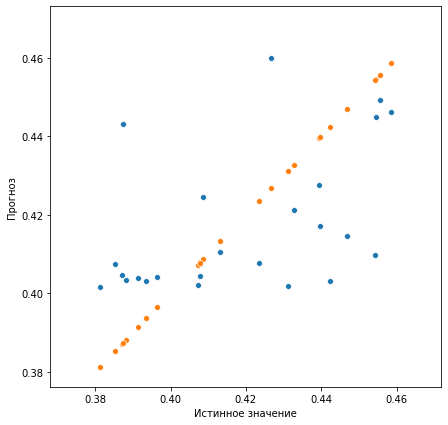

In [95]:
tree = TreeBoosting(2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

print(r2_score(y_test, y_pred))
plt.figure(figsize=(7,7))
sns.scatterplot(y_test, y_pred)
sns.scatterplot(y_test, y_test)
plt.xlabel('Истинное значение')
plt.ylabel('Прогноз')

In [83]:
tree.possible_values

array([0.40639764, 0.41315739, 0.42683001, 0.45594994])

In [92]:
lin = tree.linears[3]
print(lin.coef_)
print(lin.intercept_)

[ 9.05944059e-01 -2.78952360e-05  3.49015186e-05 -6.48761961e-05
  5.11938831e-05]
0.08745480613611983


Output #0
Length 1
Output #1
Length 7
Output #2
Length 43
Output #3
Length 16
Output #4
Length 3
Output #5
Length 18
Output #6
Length 5
Output #7
Length 6
0.7453905359254382


Text(0, 0.5, 'Прогноз')

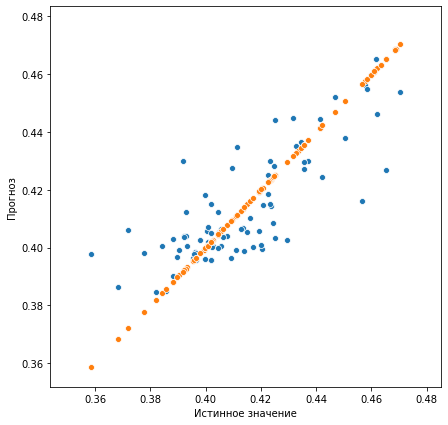

In [97]:
tree = TreeBoosting(3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

tree.fit(X_train, y_train)

y_pred = tree.predict(X_train)

print(r2_score(y_train, y_pred))
plt.figure(figsize=(7,7))
sns.scatterplot(y_train, y_pred)
sns.scatterplot(y_train, y_train)
plt.xlabel('Истинное значение')
plt.ylabel('Прогноз')